In [ ]:

import kagglehub
kagglehub.login()


Kaggle credentials set.
Kaggle credentials successfully validated.


In [ ]:

salmasuraiya_fvision_path = kagglehub.dataset_download('salmasuraiya/fvision')

print('Data source import complete.')
print(f'Dataset downloaded to: {salmasuraiya_fvision_path}')

100%|██████████| 856M/856M [00:11<00:00, 80.0MB/s]

Extracting files...


Data source import complete.
Dataset downloaded to: /root/.cache/kagglehub/datasets/salmasuraiya/fvision/versions/1


In [ ]:
!pip install -q lightly torchvision torch --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 859.3/859.3 kB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.6/165.6 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 56.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 64.7 MB/s eta 0:00:00


In [ ]:
import os
import shutil
from pathlib import Path
from collections import defaultdict
import csv


SRC = Path("/root/.cache/kagglehub/datasets/salmasuraiya/fvision/versions/1/Fruits Original-ML-GRP-07")  # your source dataset
DEST = Path("/kaggle/working/fruits_15cls")                    # output (writeable)
IMAGE_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp"}
VALID_CONDS = {"fresh": "Fresh", "rotten": "Rotten", "formalin": "Formalin"}  # normalize
DRY_RUN = False


def is_image(p: Path):
    return p.is_file() and p.suffix.lower() in IMAGE_EXTS

def safe_mkdir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def norm_name(s: str):

    return "".join(ch for ch in s.lower() if ch.isalnum())


if not SRC.exists():
    raise FileNotFoundError(f"Source path not found: {SRC}")

safe_mkdir(DEST)
counts = defaultdict(int)
skipped = []

# Fruit folders (Apple, Banana, Grape, Mango, Orange)
for fruit_dir in sorted([d for d in SRC.iterdir() if d.is_dir()]):
    fruit = fruit_dir.name.strip()
    # Condition subfolders (Fresh, Rotten, Formalin)
    for cond_dir in sorted([d for d in fruit_dir.iterdir() if d.is_dir()]):
        cond_key = norm_name(cond_dir.name)
        if cond_key not in VALID_CONDS:

            skipped.append(("unrecognized_condition_folder", str(cond_dir)))
            continue

        cond = VALID_CONDS[cond_key]
        class_name = f"{fruit}_{cond}"
        class_out = DEST / class_name
        safe_mkdir(class_out)

        for file in cond_dir.rglob("*"):
            if not is_image(file):
                continue

            rel = file.name

            out_name = f"{fruit}_{cond}_{rel}"
            out_path = class_out / out_name

            if DRY_RUN:
                counts[class_name] += 1
                continue

            try:
                shutil.copy2(file, out_path)
                counts[class_name] += 1
            except Exception as e:
                skipped.append((str(e), str(file)))


report_txt = DEST / "_build_report.txt"
with report_txt.open("w", encoding="utf-8") as f:
    total = sum(counts.values())
    f.write("15-class dataset build report\n")
    f.write(f"Source: {SRC}\n")
    f.write(f"Destination: {DEST}\n")
    f.write(f"Total images copied: {total}\n\n")
    for k in sorted(counts):
        f.write(f"{k}: {counts[k]}\n")
    if skipped:
        f.write("\nSkipped items:\n")
        for reason, path in skipped:
            f.write(f"- {reason}: {path}\n")

with (DEST / "_class_counts.csv").open("w", newline="", encoding="utf-8") as f:
    w = csv.writer(f)
    w.writerow(["class", "count"])
    for k in sorted(counts):
        w.writerow([k, counts[k]])

print("Done!")
print(f"Output root: {DEST}")
print("Per-class counts:")
for k in sorted(counts):
    print(f"  {k}: {counts[k]}")
if skipped:
    print(f"\nSkipped {len(skipped)} items. See {report_txt} for details.")

Done!
Output root: /kaggle/working/fruits_15cls
Per-class counts:
  Apple_Fresh: 765
  Apple_Rotten: 630
  Banana_Fresh: 749
  Banana_Rotten: 632
  Grape_Fresh: 770
  Grape_Rotten: 630
  Mango_Fresh: 762
  Mango_Rotten: 630
  Orange_Fresh: 753
  Orange_Rotten: 656

Skipped 5 items. See /kaggle/working/fruits_15cls/_build_report.txt for details.


In [ ]:
import shutil
from pathlib import Path

# root of dataset
DATA_DIR = Path("/kaggle/working/fruits_15cls")

# folders to remove
to_delete = ["Grape_Fresh", "Orange_Fresh", 'Orange_Rotten', 'Grape_Rotten']

for cls in to_delete:
    folder = DATA_DIR / cls
    if folder.exists() and folder.is_dir():
        shutil.rmtree(folder)
        print(f"Deleted: {folder}")
    else:
        print(f"Not found: {folder}")


Deleted: /kaggle/working/fruits_15cls/Grape_Fresh
Deleted: /kaggle/working/fruits_15cls/Orange_Fresh
Deleted: /kaggle/working/fruits_15cls/Orange_Rotten
Deleted: /kaggle/working/fruits_15cls/Grape_Rotten


In [ ]:


import os, copy, random
from pathlib import Path
import numpy as np
import pytorch_lightning as pl
import torch
import torchvision
from torch import nn

from lightly.data import LightlyDataset
from lightly.loss import NTXentLoss
from lightly.models.modules import MoCoProjectionHead
from lightly.models.utils import deactivate_requires_grad, update_momentum
from lightly.transforms.moco_transform import MoCoV2Transform
from lightly.utils.scheduler import cosine_schedule


# Config

DATA_DIR = "/kaggle/working/fruits_15cls"
INPUT_SIZE = 224
BATCH_SIZE = 256
EPOCHS = 20
BASE_LR = 0.06
NUM_WORKERS = 4
SEED = 42


# Reproducibility

pl.seed_everything(SEED, workers=True)
torch.backends.cudnn.benchmark = True  # speed



class MoCo(pl.LightningModule):
    def __init__(self, max_epochs=200, base_m=0.996):
        super().__init__()
        resnet = torchvision.models.resnet18(weights=None)
        # backbone without the final FC
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])  # (B, 512, 1, 1)
        self.projection_head = MoCoProjectionHead(512, 512, 128)

        # momentum models
        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)
        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)


        self.criterion = NTXentLoss(memory_bank_size=4096, temperature=0.5)

        self.max_epochs = max_epochs
        self.base_m = base_m

    def forward(self, x):
        q = self.backbone(x).flatten(start_dim=1)       # (B, 512)
        q = self.projection_head(q)                     # (B, 128)
        return q

    @torch.no_grad()
    def forward_momentum(self, x):
        k = self.backbone_momentum(x).flatten(start_dim=1)
        k = self.projection_head_momentum(k).detach()
        return k

    def training_step(self, batch, batch_idx):
        # cosine schedule for momentum m \in [base_m, 1.0]
        m = cosine_schedule(self.current_epoch, self.max_epochs, self.base_m, 1.0)
        update_momentum(self.backbone, self.backbone_momentum, m=m)
        update_momentum(self.projection_head, self.projection_head_momentum, m=m)

        (x_q, x_k) = batch[0]
        q = self(x_q)
        k = self.forward_momentum(x_k)
        loss = self.criterion(q, k)

        # log for progress bar and epoch aggregation
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=False)
        return loss

    def configure_optimizers(self):

        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=BASE_LR,
            momentum=0.9,
            weight_decay=1e-4,
            nesterov=False,
        )
        # Cosine LR (optional); for short runs, a simple constant LR also works.
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=self.max_epochs)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "interval": "epoch"}}

# Data (LightlyDataset)

if not Path(DATA_DIR).exists():
    raise FileNotFoundError(f"DATA_DIR not found: {DATA_DIR}")

# MoCo v2 augmentations; tuned for 224px and natural images
transform = MoCoV2Transform(
    input_size=INPUT_SIZE,

)

dataset = LightlyDataset(input_dir=DATA_DIR, transform=transform)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True if NUM_WORKERS > 0 else False,
)

print(f"Found {len(dataset)} images at {DATA_DIR}")


# Callbacks to print epoch losses

class EpochLossPrinter(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):

        loss_epoch = trainer.callback_metrics.get("train_loss_epoch")
        lr = trainer.optimizers[0].param_groups[0]["lr"] if trainer.optimizers else None
        if loss_epoch is not None:
            if lr is not None:
                print(f"Epoch {trainer.current_epoch:03d} | loss: {loss_epoch:.4f} | lr: {lr:.5f}")
            else:
                print(f"Epoch {trainer.current_epoch:03d} | loss: {loss_epoch:.4f}")

loss_printer = EpochLossPrinter()


# Trainer (T4-friendly)

accelerator = "gpu" if torch.cuda.is_available() else "cpu"
model = MoCo(max_epochs=EPOCHS, base_m=0.996)

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    devices=1,
    accelerator=accelerator,
    precision="16-mixed",
    gradient_clip_val=1.0,
    log_every_n_steps=20,
    enable_checkpointing=False,
    callbacks=[loss_printer],
)

trainer.fit(model=model, train_dataloaders=dataloader)


INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Found 4168 images at /kaggle/working/fruits_15cls


/usr/local/lib/python3.12/dist-packages/lightly/models/modules/memory_bank.py:89: UserWarning: Memory bank size 'size=4096' does not specify feature dimension. It is recommended to set the feature dimension with 'size=(n, dim)' when creating the memory bank. Distributed training might fail if the feature dimension is not set.
  warnings.warn(
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/model_summary/model_summary.py:231: Precision 16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.
INFO:

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/pytorch_lightning/utilities/data.py:79: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 256. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [ ]:
# Linear evaluation on labeled folder

import os, copy, time
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit


# Config

DATA_DIR = "/kaggle/working/fruits_15cls"
IMG_SIZE = 224
BATCH_SIZE = 128
EPOCHS = 20
LR = 1e-3
WD = 1e-4
VAL_RATIO = 0.2
NUM_WORKERS = 4
SEED = 42

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(SEED)
np.random.seed(SEED)

# Backbone (from MoCo) + Linear head

def get_backbone_from_moco_or_fallback():

    if 'model' in globals() and hasattr(model, 'backbone'):
        backbone = copy.deepcopy(model.backbone).eval()
        print("Loaded backbone from MoCo model in memory.")
        return backbone
    else:
        print("WARNING: MoCo model not found; using torchvision ResNet18 weights=None as fallback.")
        resnet = torchvision.models.resnet18(weights=None)
        backbone = nn.Sequential(*list(resnet.children())[:-1])
        return backbone

backbone = get_backbone_from_moco_or_fallback()

for p in backbone.parameters():
    p.requires_grad = False


feat_dim = 512
classifier = nn.Linear(feat_dim, 1000)

# Data

train_tf = T.Compose([
    T.Resize(256),
    T.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    T.RandomHorizontalFlip(p=0.5),
    T.ColorJitter(0.2, 0.2, 0.2, 0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
val_tf = T.Compose([
    T.Resize(256),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

full_ds = ImageFolder(DATA_DIR, transform=train_tf)
class_names = full_ds.classes
num_classes = len(class_names)
print(f"Detected {num_classes} classes: {class_names}")

# Rebuild classifier with correct output dim
classifier = nn.Linear(feat_dim, num_classes)

# Stratified split
targets = np.array([full_ds.samples[i][1] for i in range(len(full_ds))])
sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_RATIO, random_state=SEED)
train_idx, val_idx = next(sss.split(np.zeros_like(targets), targets))

train_ds = Subset(ImageFolder(DATA_DIR, transform=train_tf), train_idx)
val_ds   = Subset(ImageFolder(DATA_DIR, transform=val_tf),   val_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=(device=="cuda"), drop_last=False)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device=="cuda"), drop_last=False)

print(f"Train: {len(train_ds)} | Val: {len(val_ds)}")

# Downstream model (frozen backbone + linear head)

class LinearProbe(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        self.head = nn.Linear(feat_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            feats = self.backbone(x)
        feats = feats.flatten(1)
        logits = self.head(feats)
        return logits

downstream_model = LinearProbe(backbone, num_classes).to(device)


# Optimizer / AMP

optimizer = torch.optim.AdamW(downstream_model.head.parameters(), lr=LR, weight_decay=WD)
scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))
criterion = nn.CrossEntropyLoss()


# Train / Val loops

def run_epoch(model, loader, train: bool):
    model.train(train)
    total_loss, total_correct, total = 0.0, 0, 0
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        with torch.cuda.amp.autocast(enabled=(device=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)

        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        total_loss += loss.item() * y.size(0)
        preds = logits.argmax(1)
        total_correct += (preds == y).sum().item()
        total += y.size(0)

    avg_loss = total_loss / max(total, 1)
    acc = total_correct / max(total, 1)
    return avg_loss, acc

best_val_acc = 0.0
best_path = "linear_probe_best.pth"

print("\nStarting linear evaluation...")
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss, train_acc = run_epoch(downstream_model, train_loader, train=True)
    val_loss,   val_acc   = run_epoch(downstream_model, val_loader,   train=False)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            "state_dict": downstream_model.state_dict(),
            "class_names": class_names,
            "config": {"feat_dim": feat_dim, "num_classes": num_classes, "img_size": IMG_SIZE}
        }, best_path)

    dt = time.time() - t0
    print(f"Epoch {epoch:02d}/{EPOCHS} | "
          f"train_loss: {train_loss:.4f} acc: {train_acc:.4f} | "
          f"val_loss: {val_loss:.4f} acc: {val_acc:.4f} | "
          f"best_val_acc: {best_val_acc:.4f} | {dt:.1f}s")

print(f"\nSaved best linear probe to: {best_path}")


Loaded backbone from MoCo model in memory.
Detected 6 classes: ['Apple_Fresh', 'Apple_Rotten', 'Banana_Fresh', 'Banana_Rotten', 'Mango_Fresh', 'Mango_Rotten']
Train: 3334 | Val: 834

Starting linear evaluation...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-1180877443.py:120: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=="cuda"))
/tmp/ipython-input-1180877443.py:133: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=="cuda")):


Epoch 01/20 | train_loss: 1.2665 acc: 0.5525 | val_loss: 0.8705 acc: 0.6871 | best_val_acc: 0.6871 | 109.7s
Epoch 02/20 | train_loss: 0.8706 acc: 0.6890 | val_loss: 0.7010 acc: 0.7638 | best_val_acc: 0.7638 | 104.6s
Epoch 03/20 | train_loss: 0.7682 acc: 0.7262 | val_loss: 0.6274 acc: 0.7866 | best_val_acc: 0.7866 | 105.5s
Epoch 04/20 | train_loss: 0.7214 acc: 0.7382 | val_loss: 0.5747 acc: 0.7986 | best_val_acc: 0.7986 | 103.6s
Epoch 05/20 | train_loss: 0.7069 acc: 0.7289 | val_loss: 0.5672 acc: 0.7782 | best_val_acc: 0.7986 | 105.3s
Epoch 06/20 | train_loss: 0.6732 acc: 0.7403 | val_loss: 0.5343 acc: 0.8213 | best_val_acc: 0.8213 | 105.9s
Epoch 07/20 | train_loss: 0.6473 acc: 0.7519 | val_loss: 0.4939 acc: 0.8213 | best_val_acc: 0.8213 | 104.9s
Epoch 08/20 | train_loss: 0.6468 acc: 0.7516 | val_loss: 0.4906 acc: 0.8082 | best_val_acc: 0.8213 | 106.3s
Epoch 09/20 | train_loss: 0.6183 acc: 0.7582 | val_loss: 0.4977 acc: 0.8273 | best_val_acc: 0.8273 | 105.4s
Epoch 10/20 | train_loss: 0.

In [ ]:
# DOWNSTREAM: Unsupervised classifier on extracted embeddings (Train->fit, Val->evaluate)



!pip install -q scikit-learn scipy

import os, copy, time, numpy as np, torch, torch.nn as nn, torchvision
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, silhouette_score
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt


# Config

DATA_DIR = "/kaggle/working/fruits_15cls"
IMG_SIZE = 224
BATCH_SIZE = 128
NUM_WORKERS = 4
VAL_RATIO = 0.2
SEED = 42

USE_PCA = True
PCA_DIM = 128
CLUSTERER = "kmeans"

device = "cuda" if torch.cuda.is_available() else "cpu"
rng = np.random.RandomState(SEED)
torch.manual_seed(SEED); np.random.seed(SEED)


# Backbone (MoCo if available; else fallback)

def get_backbone_from_moco_or_fallback():
    if 'model' in globals() and hasattr(model, 'backbone'):
        print("✅ Using MoCo backbone already in memory.")
        return copy.deepcopy(model.backbone).eval()
    else:
        print("⚠️  MoCo model not found; using torchvision ResNet18 (random init).")
        resnet = torchvision.models.resnet18(weights=None)
        return nn.Sequential(*list(resnet.children())[:-1]).eval()  # (B,512,1,1)

backbone = get_backbone_from_moco_or_fallback().to(device)
feat_dim = 512  # ResNet18


# Data (stratified split)

train_tf = T.Compose([
    T.Resize(256),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])
val_tf = T.Compose([
    T.Resize(256),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

full_ds_tmp = ImageFolder(DATA_DIR, transform=train_tf)
class_names = full_ds_tmp.classes
num_classes = len(class_names)
targets = np.array([full_ds_tmp.samples[i][1] for i in range(len(full_ds_tmp))])

sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_RATIO, random_state=SEED)
train_idx, val_idx = next(sss.split(np.zeros_like(targets), targets))

train_ds = Subset(ImageFolder(DATA_DIR, transform=train_tf), train_idx)
val_ds   = Subset(ImageFolder(DATA_DIR, transform=val_tf),   val_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device=="cuda"))
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=(device=="cuda"))

print(f"Classes ({num_classes}): {class_names}")
print(f"Train: {len(train_ds)} | Val: {len(val_ds)}")

# Embedding extraction

@torch.no_grad()
def extract_embeddings(loader):
    feats, ys = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True)
        f = backbone(x).flatten(1)  # (B,512)
        feats.append(f.cpu())
        ys.append(y)
    X = torch.cat(feats, dim=0).numpy().astype(np.float32)
    y = torch.cat(ys, dim=0).numpy().astype(np.int64)
    return X, y

print("Extracting embeddings...")
t0 = time.time()
X_train, y_train = extract_embeddings(train_loader)
X_val,   y_val   = extract_embeddings(val_loader)
print(f"Embeddings: Train {X_train.shape} | Val {X_val.shape} | took {time.time()-t0:.1f}s")


# Optional: standardize + PCA (common before clustering)

scaler = StandardScaler(with_mean=True, with_std=True)
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)

if USE_PCA:
    print(f"Applying PCA -> {PCA_DIM} dims …")
    pca = PCA(n_components=PCA_DIM, random_state=SEED)
    X_train_z = pca.fit_transform(X_train_s)
    X_val_z   = pca.transform(X_val_s)
else:
    X_train_z, X_val_z = X_train_s, X_val_s


# Unsupervised classifier (fit on TRAIN only)

if CLUSTERER.lower() == "kmeans":
    print("Fitting K-Means on TRAIN embeddings …")
    clusterer = KMeans(n_clusters=num_classes, n_init=20, random_state=SEED)
    train_clusters = clusterer.fit_predict(X_train_z)
    val_clusters   = clusterer.predict(X_val_z)
elif CLUSTERER.lower() == "gmm":
    print("Fitting GaussianMixture on TRAIN embeddings …")
    clusterer = GaussianMixture(n_components=num_classes, covariance_type="full",
                                random_state=SEED, n_init=5, reg_covar=1e-6)
    clusterer.fit(X_train_z)
    train_clusters = clusterer.predict(X_train_z)
    val_clusters   = clusterer.predict(X_val_z)
else:
    raise ValueError("CLUSTERER must be 'kmeans' or 'gmm'.")

# Silhouette (unsupervised quality; higher is better)
sil_train = silhouette_score(X_train_z, train_clusters) if len(np.unique(train_clusters))>1 else float('nan')
sil_val   = silhouette_score(X_val_z,   val_clusters)   if len(np.unique(val_clusters))>1   else float('nan')
print(f"Silhouette — Train: {sil_train:.3f} | Val: {sil_val:.3f}")


# Map cluster IDs -> class IDs (for evaluation ONLY)

def hungarian_map(y_true, clusters, num_classes):
    cm = confusion_matrix(y_true, clusters, labels=range(num_classes))

    cost = cm.max() - cm
    row_ind, col_ind = linear_sum_assignment(cost)
    mapping = {col: row for row, col in zip(row_ind, col_ind)}  # cluster -> class
    return mapping, cm

cluster2class_train, cm_train = hungarian_map(y_train, train_clusters, num_classes)

def apply_map(cluster_ids, mapping):
    return np.array([mapping[c] for c in cluster_ids], dtype=int)

y_pred_train = apply_map(train_clusters, cluster2class_train)
y_pred_val   = apply_map(val_clusters,   cluster2class_train)  # use train mapping on val


# Metrics (supervised evaluation of unsupervised clusters)

def report(split, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    print(f"[{split}] Acc: {acc:.4f} | Macro-F1: {f1m:.4f}")
    return acc, f1m

print("\n=== Unsupervised downstream results (Hungarian-mapped) ===")
_ = report("Train", y_train, y_pred_train)
_ = report("Val",   y_val,   y_pred_val)

# Confusion matrices (optional)
def plot_cm(y_true, y_pred, title):
    from sklearn.metrics import ConfusionMatrixDisplay
    disp = ConfusionMatrixDisplay.from_predictions(
        y_true, y_pred, display_labels=class_names, cmap="Blues", values_format="d", xticks_rotation=90
    )
    plt.title(title); plt.tight_layout(); plt.show()



✅ Using MoCo backbone already in memory.
Classes (6): ['Apple_Fresh', 'Apple_Rotten', 'Banana_Fresh', 'Banana_Rotten', 'Mango_Fresh', 'Mango_Rotten']
Train: 3334 | Val: 834
Extracting embeddings...


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Embeddings: Train (3334, 512) | Val (834, 512) | took 100.3s
Applying PCA -> 128 dims …
Fitting K-Means on TRAIN embeddings …
Silhouette — Train: 0.285 | Val: 0.286

=== Unsupervised downstream results (Hungarian-mapped) ===
[Train] Acc: 0.6059 | Macro-F1: 0.6168
[Val] Acc: 0.6187 | Macro-F1: 0.6263


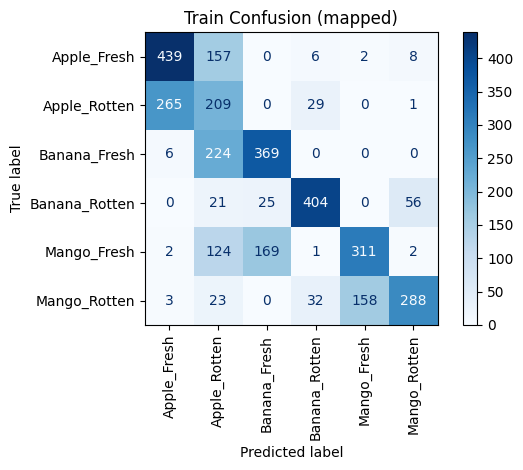

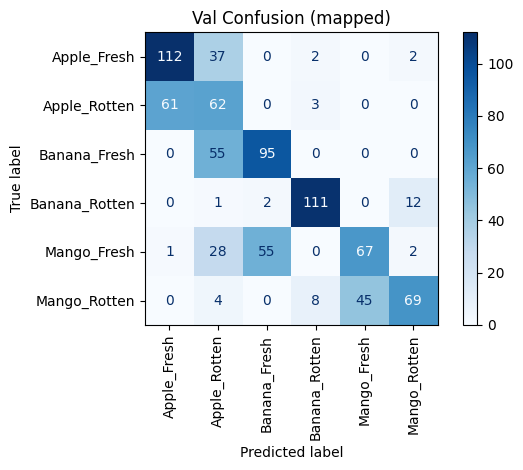

In [ ]:
plot_cm(y_train, y_pred_train, "Train Confusion (mapped)")
plot_cm(y_val,   y_pred_val,   "Val Confusion (mapped)")

Using existing cluster→class mapping from train.

[Train (Unsupervised, mapped)] Overall Acc: 0.6059 | Macro-F1: 0.6168
Per-class accuracy:
  Apple_Fresh          0.7173
  Apple_Rotten         0.4147
  Banana_Fresh         0.6160
  Banana_Rotten        0.7984
  Mango_Fresh          0.5107
  Mango_Rotten         0.5714

[Train (Unsupervised, mapped)] Classification Report:
               precision    recall  f1-score   support

  Apple_Fresh     0.6140    0.7173    0.6616       612
 Apple_Rotten     0.2757    0.4147    0.3312       504
 Banana_Fresh     0.6554    0.6160    0.6351       599
Banana_Rotten     0.8559    0.7984    0.8262       506
  Mango_Fresh     0.6603    0.5107    0.5759       609
 Mango_Rotten     0.8113    0.5714    0.6705       504

     accuracy                         0.6059      3334
    macro avg     0.6454    0.6048    0.6168      3334
 weighted avg     0.6453    0.6059    0.6176      3334



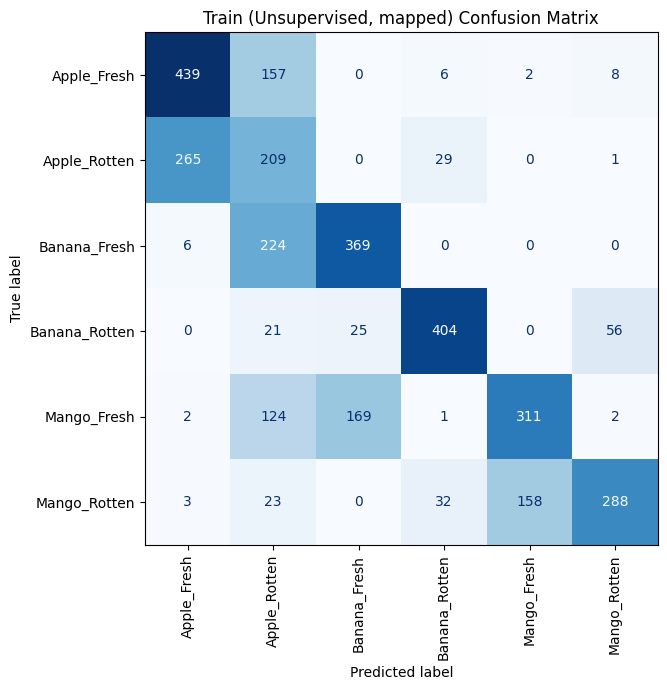


[Val (Unsupervised, mapped)] Overall Acc: 0.6187 | Macro-F1: 0.6263
Per-class accuracy:
  Apple_Fresh          0.7320
  Apple_Rotten         0.4921
  Banana_Fresh         0.6333
  Banana_Rotten        0.8810
  Mango_Fresh          0.4379
  Mango_Rotten         0.5476

[Val (Unsupervised, mapped)] Classification Report:
               precision    recall  f1-score   support

  Apple_Fresh     0.6437    0.7320    0.6850       153
 Apple_Rotten     0.3316    0.4921    0.3962       126
 Banana_Fresh     0.6250    0.6333    0.6291       150
Banana_Rotten     0.8952    0.8810    0.8880       126
  Mango_Fresh     0.5982    0.4379    0.5057       153
 Mango_Rotten     0.8118    0.5476    0.6540       126

     accuracy                         0.6187       834
    macro avg     0.6509    0.6207    0.6263       834
 weighted avg     0.6482    0.6187    0.6244       834



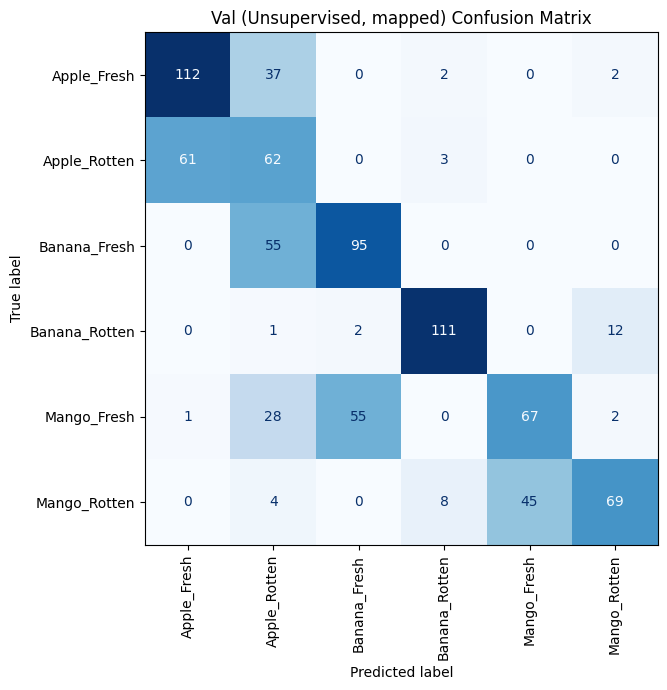

In [ ]:

# Unsupervised eval suite

# Metrics: per-class & overall accuracy, classification report, confusion matrix
# ROC/AUC: KMeans -> scores from softmax(-distance^2); GMM -> predict_proba
# Grad-CAM: requires a classifier that outputs logits (e.g., a linear probe).
# If "downstream_model" is defined, this will visualize Grad-CAM on a sample.

import numpy as np
import torch, torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report,
    confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from scipy.optimize import linear_sum_assignment
import random

# 0) Utilities
def ensure_mapping_from_train(y_train, train_clusters, num_classes):
    cm = confusion_matrix(y_train, train_clusters, labels=range(num_classes))
    cost = cm.max() - cm
    r, c = linear_sum_assignment(cost)
    return {cluster: cls for cls, cluster in zip(r, c)}, cm

def apply_map(cluster_ids, mapping):
    return np.array([mapping[c] for c in cluster_ids], dtype=int)

def per_class_accuracy(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    per_cls = {}
    for i, name in enumerate(class_names):
        denom = cm[i].sum()
        per_cls[name] = (cm[i, i] / denom) if denom > 0 else float("nan")
    return per_cls, cm

def print_metrics(y_true, y_pred, class_names, title):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    per_cls, cm = per_class_accuracy(y_true, y_pred, class_names)
    print(f"\n[{title}] Overall Acc: {acc:.4f} | Macro-F1: {f1m:.4f}")
    print("Per-class accuracy:")
    for k, v in per_cls.items():
        print(f"  {k:<20} {v:.4f}")
    print(f"\n[{title}] Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    # Confusion matrix plot
    fig, ax = plt.subplots(figsize=(8,7))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(ax=ax, xticks_rotation=90, cmap="Blues", values_format="d", colorbar=False)
    ax.set_title(f"{title} Confusion Matrix")
    plt.tight_layout(); plt.show()

#  1) Build or reuse mapping (cluster -> class)

if 'cluster2class_train' not in globals():

    if CLUSTERER.lower() == "kmeans":
        train_clusters_eval = clusterer.predict(X_train if 'pca' not in globals() else pca.transform(scaler.transform(X_train)))
    else:  # GMM
        train_clusters_eval = clusterer.predict(X_train if 'pca' not in globals() else pca.transform(scaler.transform(X_train)))
    cluster2class_train, _ = ensure_mapping_from_train(y_train, train_clusters_eval, num_classes)
    print("Derived cluster→class mapping from train via Hungarian matching.")
else:
    print("Using existing cluster→class mapping from train.")

#  2) Predictions for Train & Val using the clusterer
if CLUSTERER.lower() == "kmeans":

    if 'pca' in globals():
        X_train_eval = pca.transform(scaler.transform(X_train))
        X_val_eval   = pca.transform(scaler.transform(X_val))
    else:
        X_train_eval, X_val_eval = scaler.transform(X_train), scaler.transform(X_val)

    train_clusters = clusterer.predict(X_train_eval)
    val_clusters   = clusterer.predict(X_val_eval)

    # scores for ROC: softmax over -squared-distance to centers
    C = clusterer.cluster_centers_  # (K, D)
    def kmeans_scores(X):
        X2 = np.sum(X * X, axis=1, keepdims=True)
        C2 = np.sum(C * C, axis=1, keepdims=True).T
        XC = X @ C.T
        d2 = X2 - 2*XC + C2

        z = d2 - d2.min(axis=1, keepdims=True)
        scores = np.exp(-(z))  # exp(-d2)
        scores = scores / scores.sum(axis=1, keepdims=True)
        return scores
    train_scores = kmeans_scores(X_train_eval)
    val_scores   = kmeans_scores(X_val_eval)

elif CLUSTERER.lower() == "gmm":
    if 'pca' in globals():
        X_train_eval = pca.transform(scaler.transform(X_train))
        X_val_eval   = pca.transform(scaler.transform(X_val))
    else:
        X_train_eval, X_val_eval = scaler.transform(X_train), scaler.transform(X_val)

    train_clusters = clusterer.predict(X_train_eval)
    val_clusters   = clusterer.predict(X_val_eval)
    # scores for ROC: responsibilities
    train_scores = clusterer.predict_proba(X_train_eval)
    val_scores   = clusterer.predict_proba(X_val_eval)

else:
    raise ValueError("CLUSTERER must be 'kmeans' or 'gmm'.")

#  3) Map clusters -> classes (evaluation only)
y_pred_train = apply_map(train_clusters, cluster2class_train)
y_pred_val   = apply_map(val_clusters,   cluster2class_train)

#  4) Scalar metrics, report, confusion
print_metrics(y_train, y_pred_train, class_names, title="Train (Unsupervised, mapped)")
print_metrics(y_val,   y_pred_val,   class_names, title="Val (Unsupervised, mapped)")

# 5) Multiclass ROC & AUC (OvR)
def plot_multiclass_roc(y_true, scores, class_names, title):
    n_classes = len(class_names)
    Y = label_binarize(y_true, classes=list(range(n_classes)))  # (N,C)

    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y[:, i], scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # micro-average
    fpr['micro'], tpr['micro'], _ = roc_curve(Y.ravel(), scores.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

    # macro-average
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    plt.figure(figsize=(8,6))
    plt.plot(fpr['micro'], tpr['micro'], label=f"micro-average (AUC={roc_auc['micro']:.3f})")
    plt.plot(all_fpr, mean_tpr, label="macro-average")
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=1, alpha=0.7, label=f"{class_names[i]} (AUC={roc_auc[i]:.3f})")
    plt.plot([0,1],[0,1],"k--", lw=1)
    plt.xlim([0,1]); plt.ylim([0,1.05])
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.title(title); plt.legend(fontsize=8, ncol=2, loc="lower right")
    plt.grid(True, alpha=0.3); plt.tight_layou_
